# Overview.ipynb
This notebook provides a brief overview of the primary functions included in the LES-utils repository, including LESutils.py and spec.py. I never got around to making this a package, so you will need to add this repository to the system path in order to import functions directly. Finally, these functions were developed using a consistent conda environment, which I have exported in this directory as environment_LES.yml.

Note that this code is on the "q-default" branch of LES-utils, which assumes LES output created from the most up-to-date version of les_brg and includes humidity.

Brian R. Greene
July 2024

In [3]:
# add directory where LESutils.py, spec.py live
import os
import sys
sys.path.append(os.path.expanduser("~/LES-utils/"))
import yaml
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
# load all functions with *
from LESutils import *
from spec import *

# Raw Simulations

Simulations output directly as .out binary files, 1 per variable, per timestep defined in param.f90. The simulations also output a useful metadata file, params.yaml, with each job. This is used to provide context for the postprocessing routines.

### Objective: Convert binary files into one netcdf file per timestep.
There are five main functions in LESutils for postprocessing these raw files:

1) read_f90_bin(): can read a raw binary file and convert to 3-dimensional numpy array

2) out2netcdf(): combines raw binary files for (at present) 16 variables with metadata in yaml file to create a single netcdf file with appropriate coordinates and labels.

3) organize_output(): if a simulation has been split into multiple "chunks", this will reorganize files to be processed all at once. Also combines timeseries files into .npz files, 1 per variable (timeseries natively outputs at 1 file per variable, per mpi task).
 
4) timeseries2netcdf(): same as out2netcdf, but for timeseries files. Will combine all (at present) 16 individual .npz files into a single netcdf file with apprpriate metadata and coordinates.

5) process_raw_sim(): combines basically all of the above functions into one convenient function with optional flags for additional postprocessing such as calculating mean stats and rotating coordinates. These will be discussed later.
 
This process_raw_sim() is the main function call in practice. See ../scripts/process.py for example usage from command line by only inputting simulation directory and name.

## Let's walk through these functions individually

In [4]:
# load a raw binary file
dout = "/home/bgreene/simulations/tutorial/example03/output/"
fu = dout + "u_0100000.out"
# get sim information from yaml file
fyaml = dout + "params.yaml"
with open(fyaml) as fy:
    params = yaml.safe_load(fy)

# now we have the scales to re-dimensionalize the raw binary fields
u_scale = params["u_scale"]
# also have resolution of the simulation
nx = params["nx"]
ny = params["ny"]
nz = params["nz"]

# let's load a file
u_in = read_f90_bin(fu, nx, ny, nz, 8)
# multiply by u_scale to get velocity in m/s
u = u_in * u_scale

Reading file: /home/bgreene/simulations/tutorial/example03/output/u_0100000.out


In [5]:
# let's make a netcdf file out of this timestep: 100000
# can input full params yaml file as kwargs with ** to the out2netcdf function
# and it takes care of the rest!
# However, typically called in process_raw_sim, so for now we will need to manually
# create the default output dir
os.mkdir(dout+"netcdf/")

out2netcdf(dout, timestep=100000, del_raw=False, **params)

Reading file: /home/bgreene/simulations/tutorial/example03/output/u_0100000.out
Reading file: /home/bgreene/simulations/tutorial/example03/output/v_0100000.out
Reading file: /home/bgreene/simulations/tutorial/example03/output/w_0100000.out
Reading file: /home/bgreene/simulations/tutorial/example03/output/theta_0100000.out
Reading file: /home/bgreene/simulations/tutorial/example03/output/q_0100000.out
Reading file: /home/bgreene/simulations/tutorial/example03/output/p_0100000.out
Reading file: /home/bgreene/simulations/tutorial/example03/output/dissip_0100000.out
Reading file: /home/bgreene/simulations/tutorial/example03/output/txx_0100000.out
Reading file: /home/bgreene/simulations/tutorial/example03/output/txy_0100000.out
Reading file: /home/bgreene/simulations/tutorial/example03/output/txz_0100000.out
Reading file: /home/bgreene/simulations/tutorial/example03/output/tyy_0100000.out
Reading file: /home/bgreene/simulations/tutorial/example03/output/tyz_0100000.out
Reading file: /home/b

### Explore new file that we just created using xarray

In [6]:
# load this file using xarray
fnew = dout + "netcdf/all_0100000.nc"
d = xr.load_dataset(fnew)
# explore d
d

<xarray.Dataset>
Dimensions:  (x: 96, y: 96, z: 96)
Coordinates:
  * x        (x) float64 0.0 42.11 84.21 126.3 ... 3.916e+03 3.958e+03 4e+03
  * y        (y) float64 0.0 42.11 84.21 126.3 ... 3.916e+03 3.958e+03 4e+03
  * z        (z) float64 10.42 31.47 52.52 ... 1.968e+03 1.989e+03 2.01e+03
Data variables: (12/16)
    u        (x, y, z) float64 0.6632 0.9512 1.358 1.376 ... 1.07 1.066 1.069
    v        (x, y, z) float64 -1.896 -2.153 -1.875 ... 0.185 0.1798 0.1925
    theta    (x, y, z) float64 302.6 301.6 301.3 301.4 ... 310.6 310.6 310.7
    q        (x, y, z) float64 10.69 10.24 10.11 10.16 ... 3.149 3.127 3.11
    p        (x, y, z) float64 -0.1903 4.558 -0.6941 ... -0.5945 -0.5634 -0.4898
    w        (x, y, z) float64 0.1548 0.1254 0.0004469 ... -0.005344 0.01196
    ...       ...
    tyz      (x, y, z) float64 0.04601 0.005689 ... -1.88e-08 2.114e-09
    tzz      (x, y, z) float64 -0.02157 0.002509 ... -1.362e-07 -1.32e-09
    tw_sgs   (x, y, z) float64 0.1545 0.04203 0.008032 ... -1.958e-06 1.668e-06
    qw_sgs   (x, y, z) float64 0.06492 0.01853 0.003804 ... 6.526e-07 -5.559e-07
    dissip   (x, y, z) float64 -0.001435 -0.0001978 ... -3.448e-10 3.094e-10
    e_sgs    (x, y, z) float64 0.2691 0.3291 0.2938 ... -0.0006712 0.0001657
Attributes: (12/26)
    path:           /home/bgreene/simulations/tutorial/example03/
    nx:             96
    ny:             96
    nz:             96
    nz_mpi:         1
    Lx:             4000.0
    ...             ...
    wq_s:           0.1
    wtv_s:          0.2583
    Ug:             1.0
    Vg:             0.0
    coriol:         0.0001
    lbc:            1

We can see that this file contains 16 data variables that each have coordinates of x, y, and z. You can return the individual arrays by indexing like a dictionary or with a dot. For example, to get the u data:

u = d.u

or

u = d["u"]

In [8]:
d["u"]

<xarray.DataArray 'u' (x: 96, y: 96, z: 96)>
array([[[ 0.66319447,  0.95122372,  1.35768733, ...,  1.04693813,
          1.05001441,  1.05741273],
        [ 0.6270939 ,  1.12588574,  1.15385724, ...,  1.04825001,
          1.0471167 ,  1.04378716],
        [ 0.54405034,  0.96974535,  1.16133308, ...,  1.04013975,
          1.02556573,  1.021974  ],
        ...,
        [ 1.11226884,  0.42990087,  0.91707055, ...,  1.02445987,
          1.02086384,  1.03196178],
        [ 0.54373813,  0.66629954,  1.12467851, ...,  1.03542069,
          1.03261601,  1.05051037],
        [ 0.37105008,  0.55288661,  0.4727553 , ...,  1.04087953,
          1.04498754,  1.05803184]],

       [[ 0.92585642,  0.96405778,  0.98782995, ...,  1.03686046,
          1.03532428,  1.04104067],
        [ 1.30569491,  0.8004692 ,  0.79530469, ...,  1.02640202,
          1.03593339,  1.04189461],
        [ 1.64148078,  1.27612748,  0.78283115, ...,  1.01091018,
          1.02222664,  1.02501394],
...
        [ 0.96740671,  0.45543664,  0.47954489, ...,  1.06683452,
          1.06204865,  1.05775548],
        [ 1.21326092,  0.99503085,  0.45394128, ...,  1.08213075,
          1.07745529,  1.07295985],
        [ 0.35683286,  0.92101063,  0.97314827, ...,  1.0891627 ,
          1.08778677,  1.07371811]],

       [[ 1.11086594,  0.66485569,  1.01641417, ...,  1.07172154,
          1.06531034,  1.06656619],
        [ 0.39411069,  1.2150862 ,  1.12304305, ...,  1.05969375,
          1.05480531,  1.04973292],
        [-0.39858601,  1.27961197,  1.12106352, ...,  1.04178419,
          1.03171189,  1.02656622],
        ...,
        [ 0.29401653,  1.25637513,  0.25533524, ...,  1.04364964,
          1.04348578,  1.04463408],
        [ 0.43651029,  0.9898006 ,  0.68364382, ...,  1.06193795,
          1.05590929,  1.06267675],
        [ 0.58456974,  0.86082   ,  0.97225419, ...,  1.07006202,
          1.06604499,  1.06873206]]])
Coordinates:
  * x        (x) float64 0.0 42.11 84.21 126.3 ... 3.916e+03 3.958e+03 4e+03
  * y        (y) float64 0.0 42.11 84.21 126.3 ... 3.916e+03 3.958e+03 4e+03
  * z        (z) float64 10.42 31.47 52.52 ... 1.968e+03 1.989e+03 2.01e+03
Attributes:
    units:    m/s

In [9]:
# how does organize_output() work?
# call with nrun = 1 on this simulation to effectively just organize timeseries data
organize_output(dout, 1)

Begin run: 1
Moving volume files: u
Moving volume files: v
Moving volume files: w
Moving volume files: theta
Moving volume files: q
Moving volume files: p
Moving volume files: txx
Moving volume files: txy
Moving volume files: txz
Moving volume files: tyy
Moving volume files: tyz
Moving volume files: tzz
Moving volume files: sgs_t3
Moving volume files: sgs_q3
Moving volume files: e_sgs
Moving volume files: dissip
Moving timeseries files...
Saving file: /home/bgreene/simulations/tutorial/example03/output/runall/u_timeseries_run01.npz
Moving timeseries files...
Saving file: /home/bgreene/simulations/tutorial/example03/output/runall/v_timeseries_run01.npz
Moving timeseries files...
Saving file: /home/bgreene/simulations/tutorial/example03/output/runall/w_timeseries_run01.npz
Moving timeseries files...
Saving file: /home/bgreene/simulations/tutorial/example03/output/runall/t_timeseries_run01.npz
Moving timeseries files...
Saving file: /home/bgreene/simulations/tutorial/example03/output/runa

In [11]:
# timeseries2netcdf works basically the same way as out2netcdf
params['simlabel'] = 'example03'
timeseries2netcdf(dout=dout, dnc=dout+"netcdf/", del_npz=False, **params)

Processing simulation example03
Timestsps in npz files: 432000 = final 6 hrs of sim
Finished saving timeseries for simulation example03


# Calculate Mean Statistics

After calling out2netcdf on each desired timestep, can average in time and horizontal slabs of this 4D dataset to reduce the coordinates to just be a function of height. We do this by calling calc_stats(). This can be used by specifying either the number of hours to average over (code will determine which files to process) or specifically enter the desired files. Note that the params dataset will need to have the following variables specified to run properly outside of process_raw_sim(): "nhr_s", "dnc", which stand for the averaging window and the netcdf directory, respectively.

In [12]:
# let's call calc_stats() on the file we created earlier
# assign parameters
params["dnc"] = dout + "netcdf/"
# just label as the filenumber, typically something like "5-6h"
params["nhr_s"] = "0100000"
params["simlabel"] = "example03"
# if we add the key "return_fstats", then this function will return the filename it makes
params["return_fstats"] = True

fstats = calc_stats(f_use=[fnew], nhr=None, **params)

Loading file: /home/bgreene/simulations/tutorial/example03/output/netcdf/all_0100000.nc
Saving file: /home/bgreene/simulations/tutorial/example03/output/netcdf/mean_stats_xyt_0100000.nc
Finished!


In [13]:
# load this new stats file
stats = xr.load_dataset(dout+"netcdf/"+fstats)
stats

<xarray.Dataset>
Dimensions:      (z: 96)
Coordinates:
  * z            (z) float64 10.42 31.47 52.52 ... 1.968e+03 1.989e+03 2.01e+03
Data variables: (12/37)
    u_mean       (z) float64 0.574 0.6604 0.7018 0.7429 ... 0.9999 1.0 1.0
    v_mean       (z) float64 0.03655 0.04921 0.06468 ... 0.0008647 0.0008082
    w_mean       (z) float64 9.702e-18 -1.136e-17 ... -7.182e-18 -1.521e-19
    theta_mean   (z) float64 302.2 301.8 301.6 301.6 ... 310.5 310.5 310.6 310.7
    q_mean       (z) float64 10.48 10.3 10.25 10.22 ... 3.178 3.157 3.135 3.114
    dissip_mean  (z) float64 -0.00531 -0.003996 ... -1.812e-07 -1.136e-07
    ...           ...
    vw_cov_tot   (z) float64 -0.001603 -0.0009743 ... 9.299e-06 4.536e-06
    tw_cov_tot   (z) float64 0.2384 0.2419 0.2166 ... -0.0002791 -0.0001266
    qw_cov_tot   (z) float64 0.1011 0.1065 0.09984 ... 9.305e-05 4.221e-05
    tvw_cov_tot  (z) float64 0.2572 0.2616 0.2352 ... -0.0002619 -0.0001188
    u_mean_rot   (z) float64 0.5752 0.6622 0.7048 0.7473 ... 0.9999 1.0 1.0
    v_mean_rot   (z) float64 0.0 -6.939e-18 0.0 0.0 ... 5.421e-20 0.0 -1.084e-19
Attributes: (12/27)
    path:           /home/bgreene/simulations/tutorial/example03/
    nx:             96
    ny:             96
    nz:             96
    nz_mpi:         1
    Lx:             4000.0
    ...             ...
    wtv_s:          0.2583
    Ug:             1.0
    Vg:             0.0
    coriol:         0.0001
    lbc:            1
    delta:          33.07085524933748

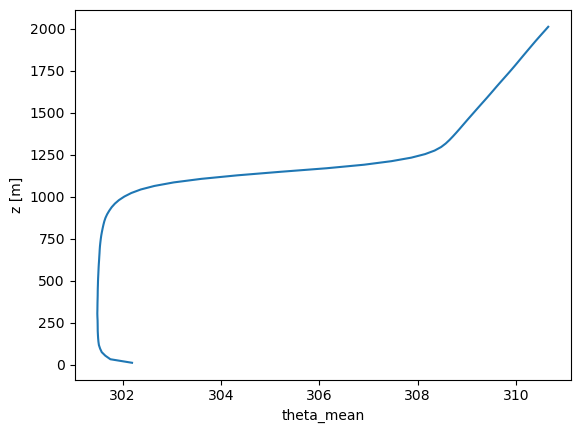

In [14]:
stats.theta_mean.plot(y="z")

Look through the variables and attributes in this dataset. There are mean first-order quantities, fluxes, variances, and both resolved and subgrid terms. However, it would be a lot more useful if we didn't have to calculate useful parameters like ABL depth, friction velocity, etc. every time we load a stats file. That's where the next function comes in handy!

In [16]:
s = load_stats(dout+"netcdf/"+fstats)
s

Reading file: /home/bgreene/simulations/tutorial/example03/output/netcdf/mean_stats_xyt_0100000.nc


<xarray.Dataset>
Dimensions:      (z: 96)
Coordinates:
  * z            (z) float64 10.42 31.47 52.52 ... 1.968e+03 1.989e+03 2.01e+03
Data variables: (12/66)
    u_mean       (z) float64 0.574 0.6604 0.7018 0.7429 ... 0.9999 1.0 1.0
    v_mean       (z) float64 0.03655 0.04921 0.06468 ... 0.0008647 0.0008082
    w_mean       (z) float64 9.702e-18 -1.136e-17 ... -7.182e-18 -1.521e-19
    theta_mean   (z) float64 302.2 301.8 301.6 301.6 ... 310.5 310.5 310.6 310.7
    q_mean       (z) float64 10.48 10.3 10.25 10.22 ... 3.178 3.157 3.135 3.114
    dissip_mean  (z) float64 -0.00531 -0.003996 ... -1.812e-07 -1.136e-07
    ...           ...
    Rtq          (z) float64 0.9209 0.9184 0.8806 0.8574 ... -1.0 -1.0 -1.0 -1.0
    Tstarc       float64 0.1703
    Qstarc       float64 0.1478
    phim         (z) float64 0.1412 0.2555 0.3099 0.3852 ... 5.953 2.622 5.727
    phih         (z) float64 0.07762 0.1028 0.0577 0.05181 ... 22.05 30.74 41.56
    zL           (z) float64 -8.912 -26.92 -44.94 ... -1.702e+03 -1.72e+03
Attributes: (12/40)
    path:           /home/bgreene/simulations/tutorial/example03/
    nx:             96
    ny:             96
    nz:             96
    nz_mpi:         1
    Lx:             4000.0
    ...             ...
    ziL:            1000
    lc:             r
    ziL_lab:        $-z_i/L = 1000$
    Ef:             0.5
    lc2:            (0.13522462068469718, 0.14196265770835692, 0.139269351350...
    Ef_lab:         $E_f = 0.5$

There are nearly twice as many more variables and attributes now in this dataset! Check out the calc_stats function code to see what each of them are. Of note, there are a few conventions I added over the years. For example, there are several boundary layer height variables. This code started being developed when I did SBL work where the convention was $h$, so that is the primary variable even in the CBL. $h$ is defined in the CBL as the height of the minimum in virtual potential temperature flux. So that is how it is stored as the "h" variable here. Similarly, "ht" is calculated as the height of the minimum in temperature flux. Finally, "zi" is the height of the maximum potential temperature gradient.

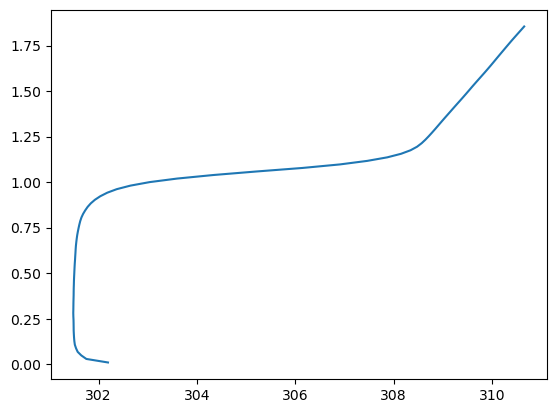

In [17]:
plt.plot(s.theta_mean, s.z/s.h)

# Rotate all fields to coordinate system in line with mean wind at all heights

For computing spectral statistics, it is important for the x-axis to match the mean wind flow. To accomplish this, we rotate our volumetric ouput about the vertical axis at every level using the nc_rotate() function. Note there is a similar function, nc_rotate_parallel, that makes use of multithreading to speed up postprocessing large simulations. The nc_rotate function is demonstrated below. This code is rather computationally expensive.

In [18]:
nc_rotate(dnc=dout+"netcdf/", t0=100000, t1=100000, dt=6000)

Saving file: all_0100000_rot.nc
Finished saving all files!


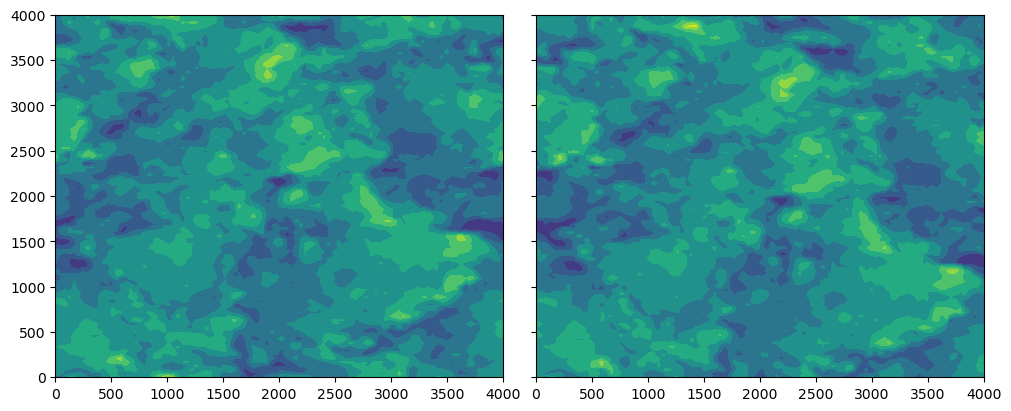

In [19]:
# load this file and compare with original
d_rot = xr.load_dataset(dout+"netcdf/all_0100000_rot.nc")

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, 
                       figsize=(10, 4), constrained_layout=True)

ax[0].contourf(d.x, d.y, d.u.isel(z=10).T)
ax[1].contourf(d_rot.x, d_rot.y, d_rot.u.isel(z=10).T)

These effects are not very dramatic as the mean wind is very weak in this simulation example.

# Put it all together: process_raw_sim

We ran through each of the individual functions, but clearly it will take some effort to loop over each output file from a simulation. That is where process_raw_sim comes into play! Check out how it runs below for the final hour of sim time of example03 (note this is a copy of example03 since we already ran the organize function earlier):

In [20]:
# call process_raw_sim on new example simulation
# define input args
# path to simulation output directory
dout = "/home/bgreene/simulations/tutorial/example03_copy/output/"
# number of hours, from end, to average over
nhr = 1
# label to give stats file that matchs nhr
nhr_s = "5-6h"
# organize file output first? (want to run timeseries2netcdf, so must be True)
organize = True
# number of batch jobs
nrun = 1
# delete raw output files at each timestep?
del_raw = False
# overwrite old files if they exist?
overwrite = True
# compute statistics?
cstats = True
# rotate coordinates?
rotate = True
# compute timeseries files?
ts2nc = True
# delete all remaining raw files?
del_remaining = False

# call process_raw_sim
fstats = process_raw_sim(dout=dout, nhr=nhr, nhr_s=nhr_s, del_raw=del_raw,
                         organize=organize, nrun=nrun,
                         overwrite=overwrite,
                         cstats=cstats, rotate=rotate,
                         ts2nc=ts2nc, del_remaining=del_remaining)

Processing 1 hours = 8 timesteps from t0=360000 to tf=432000
Begin run: 1
Moving volume files: u
Moving volume files: v
Moving volume files: w
Moving volume files: theta
Moving volume files: q
Moving volume files: p
Moving volume files: txx
Moving volume files: txy
Moving volume files: txz
Moving volume files: tyy
Moving volume files: tyz
Moving volume files: tzz
Moving volume files: sgs_t3
Moving volume files: sgs_q3
Moving volume files: e_sgs
Moving volume files: dissip
Moving timeseries files...
Saving file: /home/bgreene/simulations/tutorial/example03_copy/output/runall/u_timeseries_run01.npz
Moving timeseries files...
Saving file: /home/bgreene/simulations/tutorial/example03_copy/output/runall/v_timeseries_run01.npz
Moving timeseries files...


KeyboardInterrupt: 

# What about spectral statistics?

We can also conveniently compute things like autocorrelations, integral lengthscales, and spectrograms using the functions in spec.py. Let's quickly demonstrate the utility of a few of these.

In [22]:
# autocorrelation
# use rotated fields, compute along x, average in y (and time with more files)
# requires loaded stats file
dout = "/home/bgreene/simulations/tutorial/example03/output/"
autocorr_1d(dnc=dout+"netcdf/", fall=[dout+"netcdf/all_0100000_rot.nc"], 
            s=s, detrend="constant")

Loading file: /home/bgreene/simulations/tutorial/example03/output/netcdf/all_0100000_rot.nc
Saving file: /home/bgreene/simulations/tutorial/example03/output/netcdf/R_1d.nc
Finished computing 1d autocorrelation functions!


In [23]:
# integral lengthscales
# first need to load autocorrelation file created in previous step
R = xr.load_dataset(dout+"netcdf/R_1d.nc")
calc_lengthscale(dnc=dout+"netcdf/", R=R)

Saving file: /home/bgreene/simulations/tutorial/example03/output/netcdf/lengthscale.nc


In [24]:
# spectrograms
spectrogram(dnc=dout+"netcdf/", fall=[dout+"netcdf/all_0100000_rot.nc"],
            s=s, detrend="constant")

Loading file: /home/bgreene/simulations/tutorial/example03/output/netcdf/all_0100000_rot.nc
Computing spectra: uu
Computing spectra: ww
Computing spectra: tt
Computing spectra: qq
Computing spectra: tvtv
Computing cross spectra: uw
Computing cross spectra: tw
Computing cross spectra: qw
Computing cross spectra: tq
Computing cross spectra: tvw
Saving file: /home/bgreene/simulations/tutorial/example03/output/netcdf/spectrogram_rot.nc
Finished computing spectrograms!
